Epoch [1/20], d_loss: 1.3953936100006104, g_loss: 0.6805498003959656
Epoch [2/20], d_loss: 0.9182045459747314, g_loss: 0.6818138360977173
Epoch [3/20], d_loss: 0.7720231413841248, g_loss: 0.6806358695030212
Epoch [4/20], d_loss: 0.7501991987228394, g_loss: 0.676920473575592
Epoch [5/20], d_loss: 0.7608177065849304, g_loss: 0.6685532927513123
Epoch [6/20], d_loss: 0.7913123965263367, g_loss: 0.6496277451515198
Epoch [7/20], d_loss: 0.8310755491256714, g_loss: 0.6267550587654114
Epoch [8/20], d_loss: 0.8834459185600281, g_loss: 0.6009200811386108
Epoch [9/20], d_loss: 0.9147671461105347, g_loss: 0.5947291851043701
Epoch [10/20], d_loss: 0.9894726276397705, g_loss: 0.5707371830940247
Epoch [11/20], d_loss: 1.0350260734558105, g_loss: 0.5751103162765503
Epoch [12/20], d_loss: 1.0316884517669678, g_loss: 0.6190738677978516
Epoch [13/20], d_loss: 1.0001078844070435, g_loss: 0.704745352268219
Epoch [14/20], d_loss: 0.8916390538215637, g_loss: 0.8821684718132019
Epoch [15/20], d_loss: 0.726745

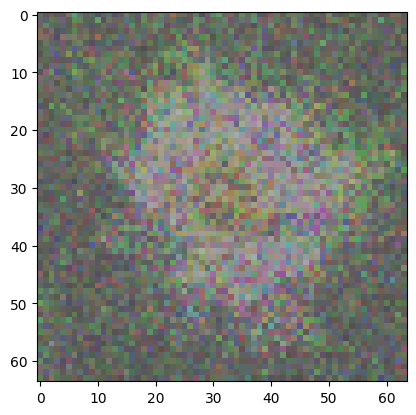

In [24]:
import os
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Image Transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load GloVe embeddings from file
def load_glove_embeddings(file_path):
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = torch.tensor([float(val) for val in values[1:]], dtype=torch.float32)
            embeddings[word] = vector
    return embeddings

# Load GloVe embeddings (set the correct path to your downloaded file)
glove_path = "C:/Users/ckula/Downloads/glove.6B.300d.txt"
glove_embeddings = load_glove_embeddings(glove_path)

# Text Embedding Function
def get_text_embedding(text, embedding_dim=300):
    tokens = text.lower().split()
    embeddings = [glove_embeddings[token] for token in tokens if token in glove_embeddings]
    if embeddings:
        return torch.mean(torch.stack(embeddings), dim=0)
    return torch.zeros(embedding_dim)

class TextToImageDataset(Dataset):
    def __init__(self, image_dir, text_dir):
        self.image_dir = image_dir
        self.text_dir = text_dir
        self.transform = transform

        # Get list of all image files
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        image_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, image_name)
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)

        # Find the corresponding text description file
        base_name = os.path.splitext(image_name)[0]  # Remove the ".jpg" extension
        txt_file = os.path.join(self.text_dir, f"{base_name}.txt")
        h5_file = os.path.join(self.text_dir, f"{base_name}.h5")

        text_description = None
        if os.path.exists(txt_file):
            with open(txt_file, 'r') as f:
                text_description = f.read().strip()
        elif os.path.exists(h5_file):
            with h5py.File(h5_file, 'r') as h5f:
                text_description = h5f['description'][()].decode('utf-8')  # Adjust key if necessary
        else:
            # Print a warning and skip if no text description is found
            print(f"Warning: No description found for image {image_name}. Skipping this item.")
            return None  # Indicate to skip this item

        # Get text embedding
        text_embedding = get_text_embedding(text_description)

        return image.to(device), text_embedding.to(device)

# Updated DataLoader to filter out None items
def collate_fn(batch):
    # Filter out items that are None
    batch = [item for item in batch if item is not None]
    return torch.utils.data.dataloader.default_collate(batch)

# Instantiate Dataset and DataLoader
image_dir = "image"  # Update with your image directory path
text_dir = "text"  # Update with your text directory path
dataset = TextToImageDataset(image_dir, text_dir)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)


# Generator Model
class Generator(nn.Module):
    def __init__(self, noise_dim, text_dim, image_channels):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(noise_dim + text_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, image_channels * 64 * 64),
            nn.Tanh()
        )

    def forward(self, noise, text_embedding):
        x = torch.cat([noise, text_embedding], dim=1)
        x = self.fc(x)
        x = x.view(x.size(0), 3, 64, 64)
        return x

# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self, image_channels, text_dim):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(image_channels * 64 * 64 + text_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, image, text_embedding):
        x = torch.cat([image.view(image.size(0), -1), text_embedding], dim=1)
        x = self.fc(x)
        return x

# Initialize models and optimizers
noise_dim = 100
text_dim = 300
image_channels = 3

generator = Generator(noise_dim, text_dim, image_channels).to(device)
discriminator = Discriminator(image_channels, text_dim).to(device)

g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
criterion = nn.BCELoss()

# Training Loop
num_epochs = 20
for epoch in range(num_epochs):
    for images, text_embeddings in data_loader:
        # Training Discriminator
        real_labels = torch.ones(images.size(0), 1).to(device)
        fake_labels = torch.zeros(images.size(0), 1).to(device)

        outputs = discriminator(images, text_embeddings)
        d_loss_real = criterion(outputs, real_labels)

        noise = torch.randn(images.size(0), noise_dim).to(device)
        fake_images = generator(noise, text_embeddings)
        outputs = discriminator(fake_images.detach(), text_embeddings)
        d_loss_fake = criterion(outputs, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Training Generator
        outputs = discriminator(fake_images, text_embeddings)
        g_loss = criterion(outputs, real_labels)
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}")

# Save the generator model
torch.save(generator.state_dict(), "generator.pth")

# Generate an image from text
def generate_image_from_text(text):
    text_embedding = get_text_embedding(text).unsqueeze(0).to(device)
    noise = torch.randn(1, noise_dim).to(device)
    generator.eval()
    with torch.no_grad():
        fake_image = generator(noise, text_embedding).cpu()
    return fake_image

# Example usage
text_input = "this flower has bright purple, spiky petals, and greenish sepals below them."
generated_image = generate_image_from_text(text_input)
plt.imshow(generated_image.squeeze(0).permute(1, 2, 0) * 0.5 + 0.5)  # Unnormalize for display
plt.show()


Epoch [1/10000], d_loss: 1.3899738788604736, g_loss: 0.722708523273468
Epoch [2/10000], d_loss: 0.8433594107627869, g_loss: 0.7194082140922546
Epoch [3/10000], d_loss: 0.7172097563743591, g_loss: 0.7135605216026306
Epoch [4/10000], d_loss: 0.710578441619873, g_loss: 0.7043867707252502
Epoch [5/10000], d_loss: 0.7266865968704224, g_loss: 0.6927781701087952
Epoch [6/10000], d_loss: 0.7640084624290466, g_loss: 0.667486310005188
Epoch [7/10000], d_loss: 0.8145682215690613, g_loss: 0.6373243927955627
Epoch [8/10000], d_loss: 0.8869224786758423, g_loss: 0.5979554653167725
Epoch [9/10000], d_loss: 0.9592236280441284, g_loss: 0.567006528377533
Epoch [10/10000], d_loss: 1.0363366603851318, g_loss: 0.544264554977417
Epoch [11/10000], d_loss: 1.0900086164474487, g_loss: 0.5425359010696411
Epoch [12/10000], d_loss: 1.0735065937042236, g_loss: 0.5853975415229797
Epoch [13/10000], d_loss: 1.045291543006897, g_loss: 0.6567886471748352
Epoch [14/10000], d_loss: 0.9220240712165833, g_loss: 0.8015909194

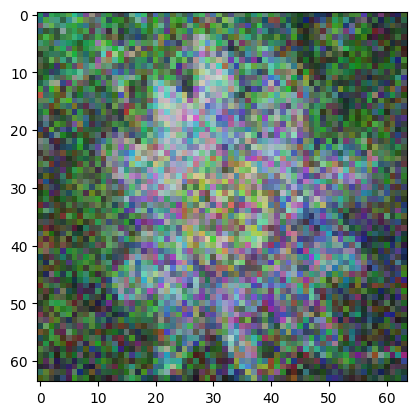

In [27]:
import os
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Image Transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load GloVe embeddings from file
def load_glove_embeddings(file_path):
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = torch.tensor([float(val) for val in values[1:]], dtype=torch.float32)
            embeddings[word] = vector
    return embeddings

# Load GloVe embeddings (set the correct path to your downloaded file)
glove_path = "C:/Users/ckula/Downloads/glove.6B.300d.txt"
glove_embeddings = load_glove_embeddings(glove_path)

# Text Embedding Function
def get_text_embedding(text, embedding_dim=300):
    tokens = text.lower().split()
    embeddings = [glove_embeddings[token] for token in tokens if token in glove_embeddings]
    if embeddings:
        return torch.mean(torch.stack(embeddings), dim=0)
    return torch.zeros(embedding_dim)

class TextToImageDataset(Dataset):
    def __init__(self, image_dir, text_dir):
        self.image_dir = image_dir
        self.text_dir = text_dir
        self.transform = transform

        # Get list of all image files
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        image_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, image_name)
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)

        # Find the corresponding text description file
        base_name = os.path.splitext(image_name)[0]  # Remove the ".jpg" extension
        txt_file = os.path.join(self.text_dir, f"{base_name}.txt")
        h5_file = os.path.join(self.text_dir, f"{base_name}.h5")

        text_description = None
        if os.path.exists(txt_file):
            with open(txt_file, 'r') as f:
                text_description = f.read().strip()
        elif os.path.exists(h5_file):
            with h5py.File(h5_file, 'r') as h5f:
                text_description = h5f['description'][()].decode('utf-8')  # Adjust key if necessary
        else:
            # Print a warning and skip if no text description is found
            print(f"Warning: No description found for image {image_name}. Skipping this item.")
            return None  # Indicate to skip this item

        # Get text embedding
        text_embedding = get_text_embedding(text_description)

        return image.to(device), text_embedding.to(device)

# Updated DataLoader to filter out None items
def collate_fn(batch):
    # Filter out items that are None
    batch = [item for item in batch if item is not None]
    return torch.utils.data.dataloader.default_collate(batch)

# Instantiate Dataset and DataLoader
image_dir = "image"  # Update with your image directory path
text_dir = "text"  # Update with your text directory path
dataset = TextToImageDataset(image_dir, text_dir)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)


# Generator Model
class Generator(nn.Module):
    def __init__(self, noise_dim, text_dim, image_channels):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(noise_dim + text_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, image_channels * 64 * 64),
            nn.Tanh()
        )

    def forward(self, noise, text_embedding):
        x = torch.cat([noise, text_embedding], dim=1)
        x = self.fc(x)
        x = x.view(x.size(0), 3, 64, 64)
        return x

# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self, image_channels, text_dim):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(image_channels * 64 * 64 + text_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, image, text_embedding):
        x = torch.cat([image.view(image.size(0), -1), text_embedding], dim=1)
        x = self.fc(x)
        return x

# Initialize models and optimizers
noise_dim = 100
text_dim = 300
image_channels = 3

generator = Generator(noise_dim, text_dim, image_channels).to(device)
discriminator = Discriminator(image_channels, text_dim).to(device)

g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
criterion = nn.BCELoss()

# Training Loop
num_epochs = 10000
for epoch in range(num_epochs):
    for images, text_embeddings in data_loader:
        # Training Discriminator
        real_labels = torch.ones(images.size(0), 1).to(device)
        fake_labels = torch.zeros(images.size(0), 1).to(device)

        outputs = discriminator(images, text_embeddings)
        d_loss_real = criterion(outputs, real_labels)

        noise = torch.randn(images.size(0), noise_dim).to(device)
        fake_images = generator(noise, text_embeddings)
        outputs = discriminator(fake_images.detach(), text_embeddings)
        d_loss_fake = criterion(outputs, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Training Generator
        outputs = discriminator(fake_images, text_embeddings)
        g_loss = criterion(outputs, real_labels)
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}")

# Save the generator model
torch.save(generator.state_dict(), "generator.pth")

# Generate an image from text
def generate_image_from_text(text):
    text_embedding = get_text_embedding(text).unsqueeze(0).to(device)
    noise = torch.randn(1, noise_dim).to(device)
    generator.eval()
    with torch.no_grad():
        fake_image = generator(noise, text_embedding).cpu()
    return fake_image

# Example usage
text_input = "spiky"
generated_image = generate_image_from_text(text_input)
plt.imshow(generated_image.squeeze(0).permute(1, 2, 0) * 0.5 + 0.5)  # Unnormalize for display
plt.show()
